In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)

### Функция для работы с .jpg - определение черных и белых пикселей в rgb пространстве

In [3]:
def is_black(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 0

def is_white(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 255

### Исходное изображение

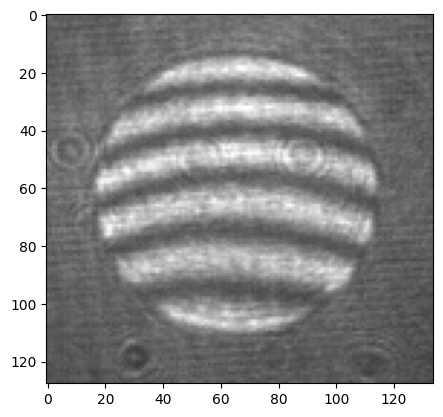

In [4]:
im = plt.imread('int.jpg')

plt.imshow(im)
plt.show()

In [5]:

# создание бинарного изображения по некоторому уровню "яркости" пикселей (работает только с .bmp)
# for bmp
# level = 150
# binary = im > level
# plt.imshow(binary)
# plt.show()

### Функция для создания бинарного изображения по уровню factor = сумма значений компонент rgb

In [6]:
def contrast (im, factor):
    #for jpg
    im2 = np.copy(im)

    for y in range(len(im2)):
        for x in range(len(im2[0])):
            current = im2[y][x]
            current_sum = sum(current)
            im2[y][x] = [0, 0, 0] if current_sum < factor else [255, 255, 255]
    return im2

### Создание бинарного изображения для определения размеров окружности, описанной вокруг интерферограммы

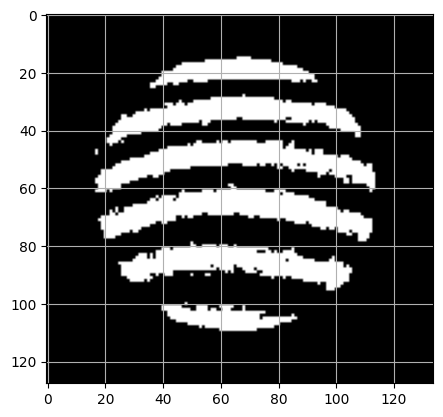

In [7]:
im2 = contrast(im, 460) #значение factor берется большим, чтобы гарантированно исключить засветы вокруг интерферограммы
plt.imshow(im2)
plt.grid()
plt.show()

### Определение центра и радиуса интерферограммы

In [8]:
top = left = (len(im2[0]), len(im2)) 
right = bottom = (0, 0)
for y in range(len(im2)):
    for x in range(len(im2[0])):
        current = im2[y][x]
        current_sum = sum(current)
        if current_sum > 0:
            if y < top[1]: top = (x, y)
            if y > bottom[1]: bottom = (x, y)
            if x < left[0]: left = (x, y)
            if x > right[0]: right = (x, y)

#print(top, left, right, bottom, sep=' ')
center_x = (left[0]+right[0])//2
center_y = (top[1]+bottom[1])//2
c_int = (center_y, center_x)
R_int = max(abs(right[0] - center_x), abs(bottom[1] - center_y))
print(c_int, R_int)

(62, 65) 48


### Показать вычисленный центр интерферограммы на рисунке

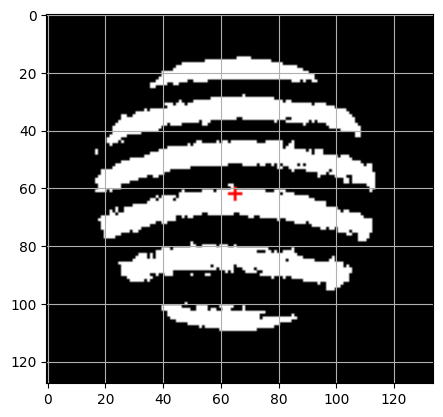

In [9]:
#center mark
color = [255, 0, 0]
im3 = np.copy(im2)
im3[center_y][center_x] = color
im3[center_y + 1][center_x] = color
im3[center_y - 1][center_x] = color
im3[center_y][center_x + 1] = color
im3[center_y][center_x - 1] = color
im3[center_y + 2][center_x] = color
im3[center_y - 2][center_x] = color
im3[center_y][center_x + 2] = color
im3[center_y][center_x - 2] = color
plt.imshow(im3)
plt.grid()
plt.show()

### Построение окружности, описывающей интерферограмму

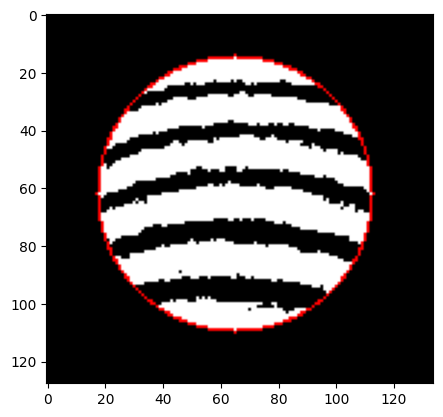

In [10]:
im4 = contrast(im, 380) #значение factor берется меньшим, чтобы не потерять информацию о форме интерференционных полос
im4_1 = np.copy(im4)
# plt.imshow(im4)
# plt.show()

int_circle_points = []

for y in range(len(im4)):
    for x in range(len(im4[0])):
        dist = math.dist(c_int, (y, x))
        if dist > R_int:                        #убирает "мусор" вне окружности
            im4[y][x] = [0, 0, 0]
            im4_1[y][x] = [0, 0, 0]
        elif (1 > R_int - dist >= 0):           #построение окружности на рисунке
            im4[y][x] = [255, 0, 0]
            int_circle_points.append((x, y))

plt.imshow(im4)
plt.show()

### Определение верхних точек интерференционных полос для аппроксимации

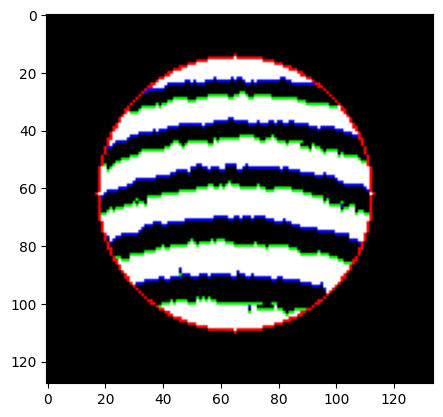

In [11]:
im5 = np.copy(im4)

curves_points_up = []
curves_points_bottom = []

#если выбранная точка белая, а точка над ней черная - запомнить и отметить
for y in range(len(im5)):
  for x in range(len(im5[0])):
    if is_black(im5[y - 1][x]) and is_white(im5[y][x]):
      im5[y][x] = [0, 255, 0]
      curves_points_up.append([x, y])

for y in range(len(im5) - 1):
  for x in range(len(im5[0])):    
    if is_black(im5[y + 1][x]) and is_white(im5[y][x]):
      im5[y][x] = [0, 0, 255]
      curves_points_bottom.append([x, y])

plt.imshow(im5)
plt.show()

### Получение информации о кривых интерферограммы

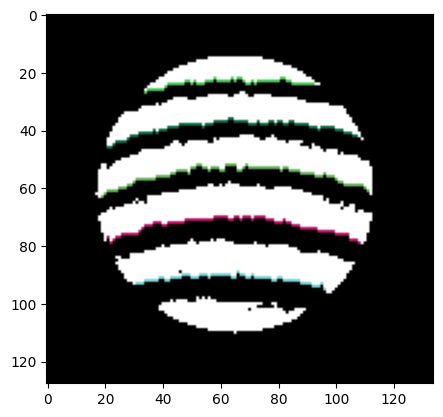

In [12]:
x_sorted_curves_points_bottom = sorted(curves_points_bottom, key=lambda p: p[0])
# print(x_sorted_curves_points_bottom)

# берется самая левая белая точка и ищется ближайшая к ней белая точка до тех пор, пока точек не останется
# когда вычисление кривой закончено, точки этой кривой удаляются из общего массива точек
def get_curve():
  fp = x_sorted_curves_points_bottom.pop(0)

  curve = [fp]

  if len(x_sorted_curves_points_bottom) == 0:
    return curve

  p = min(x_sorted_curves_points_bottom, key=lambda point: math.dist(point, fp))
  dist = math.dist(p, fp)

  #
  # настроить макисмальное растояние
  #
  while dist < 15:
    curve.append(p)
    x_sorted_curves_points_bottom.remove(p)

    x_closest = list(filter(lambda point: point[0] - curve[-1][0] == 1, x_sorted_curves_points_bottom))

    if len(x_closest) == 0:
      break

    p = min(x_closest, key=lambda point: math.dist(point, curve[-1]))
    dist = math.dist(p, curve[-1])
  
  return curve

im6 = np.copy(im4_1)

curves_bottom = [] # массив с координатами кривых

# убрать слишком короткие кривые, которые не должны участвовать в аппроксиммации
while len(x_sorted_curves_points_bottom) > 0:
  curve = get_curve()

  #
  # настроить минимальную длину
  #
  if len(curve) < 10:
    continue

  curves_bottom.append(curve)

  color = np.random.choice(range(0, 256), 3)
  for p in curve:
    im6[p[1]][p[0]] = color
    # im6[p[1] + 1][p[0]] = color
    # im6[p[1] - 1][p[0]] = color

plt.imshow(im6)
plt.show()

curves_bottom_y_sorted = sorted(curves_bottom, key = lambda p: p[len(p)//2][1])
# print(curves_bottom_y_sorted)

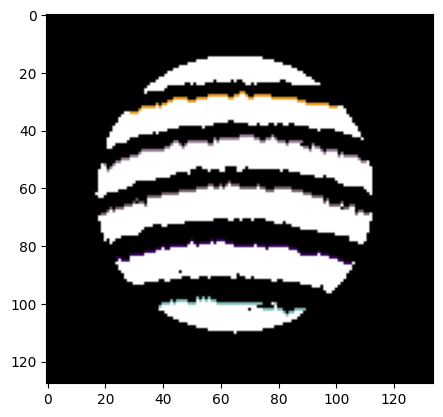

In [13]:
x_sorted_curves_points_up = sorted(curves_points_up, key=lambda p: p[0])
# print(x_sorted_curves_points_bottom)

# берется самая левая белая точка и ищется ближайшая к ней белая точка до тех пор, пока точек не останется
# когда вычисление кривой закончено, точки этой кривой удаляются из общего массива точек
def get_curve():
  fp = x_sorted_curves_points_up.pop(0)

  curve = [fp]

  if len(x_sorted_curves_points_up) == 0:
    return curve

  p = min(x_sorted_curves_points_up, key=lambda point: math.dist(point, fp))
  dist = math.dist(p, fp)

  #
  # настроить макисмальное растояние
  #
  while dist < 15:
    curve.append(p)
    x_sorted_curves_points_up.remove(p)

    x_closest = list(filter(lambda point: point[0] - curve[-1][0] == 1, x_sorted_curves_points_up))

    if len(x_closest) == 0:
      break

    p = min(x_closest, key=lambda point: math.dist(point, curve[-1]))
    dist = math.dist(p, curve[-1])
  
  return curve

im7 = np.copy(im4_1)

curves_up = [] # массив с координатами кривых

# убрать слишком короткие кривые, которые не должны участвовать в аппроксиммации
while len(x_sorted_curves_points_up) > 0:
  curve = get_curve()

  #
  # настроить минимальную длину
  #
  if len(curve) < 10:
    continue

  curves_up.append(curve)

  color = np.random.choice(range(0, 256), 3)
  for p in curve:
    im7[p[1]][p[0]] = color
    # im6[p[1] + 1][p[0]] = color
    # im6[p[1] - 1][p[0]] = color

plt.imshow(im7)
plt.show()

curves_up_y_sorted = sorted(curves_up, key = lambda p: p[len(p)//2][1])
# print(curves_up_y_sorted)

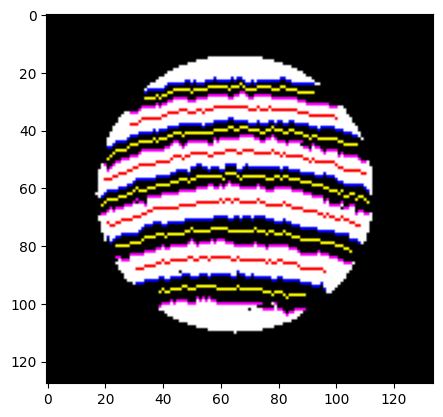

In [14]:
im8 = np.copy(im4_1)

for i in range (len(curves_up_y_sorted)):
    min_len_local = min(len(curves_up_y_sorted[i]), len(curves_bottom_y_sorted[i]))
    max_len_local = max(len(curves_up_y_sorted[i]), len(curves_bottom_y_sorted[i]))
    len_diff = max_len_local - min_len_local
    # print(min_len_local)

    for j in range(len(curves_up_y_sorted[i])):
        im8[curves_up_y_sorted[i][j][1]][curves_up_y_sorted[i][j][0]] = [255, 0, 255]

    for j in range(len(curves_bottom_y_sorted[i])):
        im8[curves_bottom_y_sorted[i][j][1]][curves_bottom_y_sorted[i][j][0]] = [0, 0, 255]

    # print((max_len_local - min_len_local) // 2)


def find_avg_curves(curves_1, curves_2, curves, color):
    for i in range(min(len(curves_1), len(curves_2))):
        up_curve = curves_1[i]
        bm_curve = curves_2[i]

        (short_curve, long_curve) = (up_curve, bm_curve) if len(up_curve) < len(bm_curve) else (bm_curve, up_curve)

        curve = []
        for point in short_curve:
            pair_point = list(filter(lambda p: p[0] == point[0], long_curve))[0]

            avg_point = (point[0], (point[1] + pair_point[1]) / 2)
            curve.append(avg_point)

            avg_point_int_y = int(avg_point[1])
            im8[avg_point_int_y][avg_point[0]] = color

        curves.append(curve)

black_curves = []
white_curves = []

find_avg_curves(curves_bottom_y_sorted, curves_up_y_sorted, black_curves, [255, 255, 0])
find_avg_curves(curves_bottom_y_sorted[1:], curves_up_y_sorted[:-1], white_curves, [255, 0, 0])

plt.imshow(im8)
plt.show()
# print(curves)

### Аппроксимация кривых интерферограммы с помощью МНК

          2
0.003605 x - 0.4844 x + 41.63
            3            2
-1.359e-05 x + 0.006172 x - 0.6391 x + 44.58
           4             3           2
1.792e-06 x - 0.0004652 x + 0.04751 x - 2.263 x + 67.62


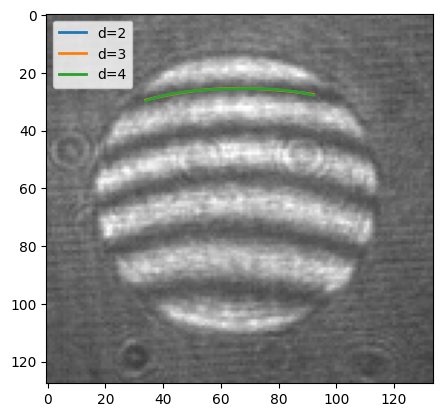

          2
0.003989 x - 0.5451 x + 58.53
           3            2
-1.03e-05 x + 0.005967 x - 0.66 x + 60.49
           4             3           2
3.444e-07 x - 9.848e-05 x + 0.01387 x - 0.9497 x + 64.08


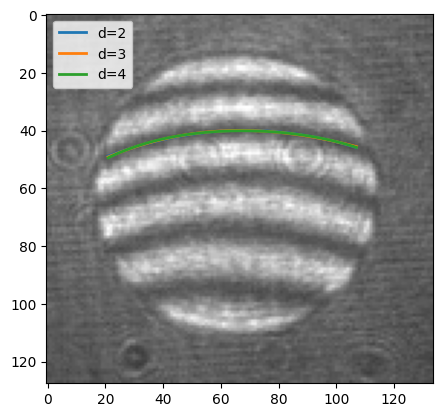

          2
0.004436 x - 0.5862 x + 75.38
           3            2
8.328e-07 x + 0.004273 x - 0.5767 x + 75.23
            4             3            2
-7.433e-08 x + 2.016e-05 x + 0.002527 x - 0.5129 x + 74.45


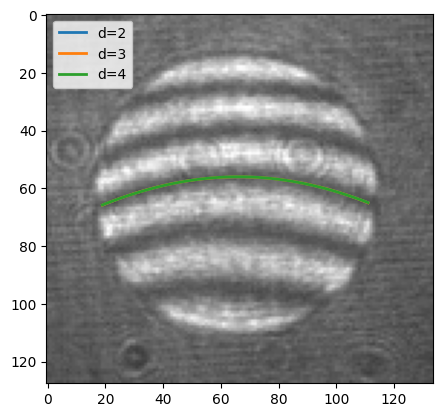

          2
0.004088 x - 0.5139 x + 90.83
            3           2
-1.572e-05 x + 0.00713 x - 0.6942 x + 94.03
           4             3            2
-2.06e-07 x + 3.743e-05 x + 0.002284 x - 0.5114 x + 91.64


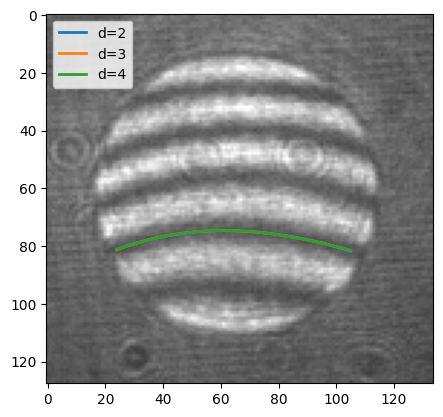

          2
0.003031 x - 0.3401 x + 104.3
            3           2
-6.643e-05 x + 0.01579 x - 1.131 x + 120.1
            4             3           2
-2.052e-06 x + 0.0004588 x - 0.03349 x + 0.8746 x + 90.28


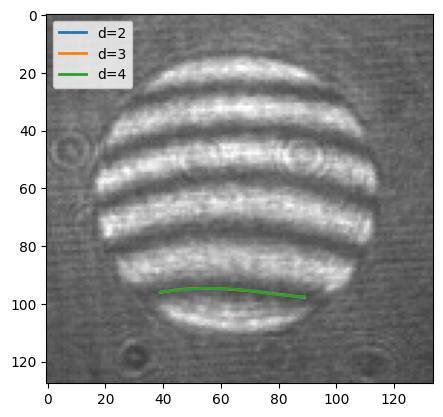

          2
0.003533 x - 0.4809 x + 48.92
            3            2
-1.366e-05 x + 0.006177 x - 0.6408 x + 51.9
            4             3            2
-9.663e-08 x + 1.127e-05 x + 0.003872 x - 0.5509 x + 50.66


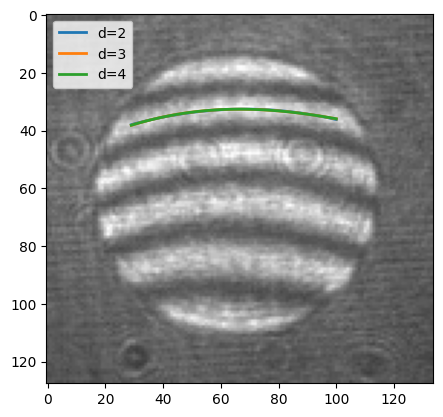

          2
0.004301 x - 0.578 x + 67.18
            3            2
-4.181e-06 x + 0.005116 x - 0.6258 x + 67.99
            4             3           2
-3.662e-09 x - 3.229e-06 x + 0.00503 x - 0.6226 x + 67.95


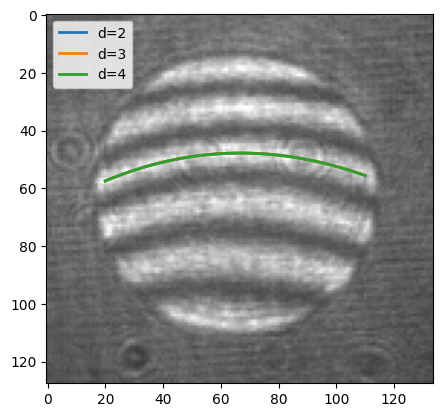

          2
0.004499 x - 0.5795 x + 83.51
            3            2
-3.428e-08 x + 0.004506 x - 0.5798 x + 83.52
            4             3             2
-1.736e-07 x + 4.477e-05 x + 0.0004594 x - 0.4306 x + 81.66


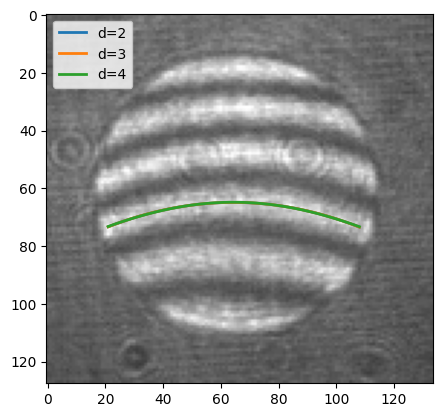

          2
0.003668 x - 0.4467 x + 98.18
            3            2
-2.295e-05 x + 0.008039 x - 0.7093 x + 103.1
           4             3           2
1.433e-07 x - 5.934e-05 x + 0.01137 x - 0.8391 x + 104.9


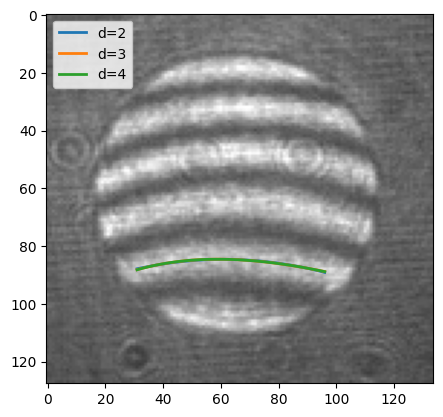

In [15]:
def poly(curve):
  x = list(map(lambda p: p[0], curve))
  y = list(map(lambda p: p[1], curve))

  legend = []
  polynom = None
  for d in range(2, 5):
    fp, residuals, rank, sv, rcond = np.polyfit(x, y, d, full=True) # d - степень полинома

    f = np.poly1d(fp)
    if d == 4: 
      polynom = f

    print(f)
    plt.plot(x, f(x), linewidth=2)
    legend.append("d=%i" % f.order)

  plt.imshow(im)
  plt.legend(legend, loc="upper left")
  plt.show()

  return polynom

black_polynoms = []
white_polynoms = []

for curve in black_curves:
  black_polynoms.append(poly(curve))

for curve in white_curves:
  white_polynoms.append(poly(curve))

In [16]:
def get_closest_cross_point_with_int_circle(point, polynom):
  max_dist = 20
  max_eps = 0.5
  possible_cross_points = list(filter(lambda p: math.dist(p, point) < max_dist, int_circle_points))

  for p in possible_cross_points:
    computed_y = polynom(p[0])

    if computed_y - p[1] < max_eps:
      return (p[0], computed_y)

bcp = []
wcp = []

print('BLACK CURVES')
for i in range(len(black_curves)):
  points = (
    get_closest_cross_point_with_int_circle(black_curves[i][0], black_polynoms[i]),
    black_curves[i][len(black_curves[i]) // 2],
    get_closest_cross_point_with_int_circle(black_curves[i][-1], black_polynoms[i])
  )

  bcp.append(points)
  print(points)

print('WHITE CURVES')
for i in range(len(white_curves)):
  points = (
    get_closest_cross_point_with_int_circle(white_curves[i][0], white_polynoms[i]),
    white_curves[i][len(white_curves[i]) // 2],
    get_closest_cross_point_with_int_circle(white_curves[i][-1], white_polynoms[i])
  )

  wcp.append(points)
  print(points)

BLACK CURVES
((28, 32.391632035380624), (63, 26.0), (100, 30.44775600440299))
((19, 50.41689240010267), (64, 39.5), (110, 46.83601162298296))
((18, 66.1461642576729), (65, 55.5), (112, 65.3213479644134))
((22, 81.85033084751252), (65, 75.0), (108, 82.18157835703136))
((33, 96.72261236357187), (64, 95.5), (97, 97.07601331908403))
WHITE CURVES
((23, 40.14666916907415), (65, 32.5), (105, 36.80068757079067))
((18, 58.357042112243214), (65, 47.5), (112, 56.2051159566532))
((19, 73.92695704082642), (65, 64.5), (111, 74.38506523690276))
((27, 89.45719721707023), (64, 85.0), (103, 90.41797706739708))


h = 9.78215761818982
H = 8.0
N1 = 0.6113848511368638
N0 = 1.1113848511368638
hwf = 644.3996330982544 nm


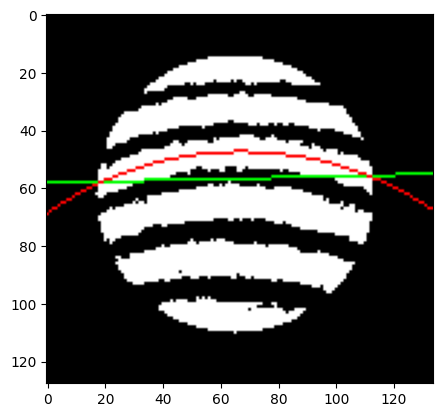

In [37]:
def line (x, k, b):
    return k * x + b

def circle (x, center, R):
    return -np.sqrt(R**2 - (x - center[0])**2) + center[1]

x1 = wcp[1][0][0]
y1 = wcp[1][0][1]
x2 = wcp[1][1][0]
y2 = wcp[1][1][1]
x3 = wcp[1][2][0]
y3 = wcp[1][2][1]

chord1_mid = ((x1 + x2) / 2, (y1 + y2) / 2)
chord2_mid = ((x2 + x3) / 2, (y2 + y3) / 2)

chord1_k = (y1 - y2) / (x1 - x2)
chord1_b = (-x2 * y1 + x1 * y2) / (x1 - x2)
chord2_k = (y2 - y3) / (x2 - x3)
chord2_b = (-x3 * y2 + x2 * y3) / (x2 - x3)
chord3_k = (y1 - y3) / (x1 - x3)
chord3_b = (-x3 * y1 + x1 * y3) / (x1 - x3)

chord1p_k = -(x1 - x2) / (y1 - y2)
chord1p_b = chord1_mid[1] - chord1p_k * chord1_mid[0]
chord2p_k = -(x2 - x3) / (y2 - y3)
chord2p_b = chord2_mid[1] - chord2p_k * chord2_mid[0]

# print(chord1p_k, chord1p_b, chord2p_k, chord2p_b)

im9 = np.copy(im4_1)

for i in range (len(im9[0])):
#     if 0 <= int(line(i, chord1_k, chord1_b)) < len(im9):
#         im9[int(line(i, chord1_k, chord1_b))][i] = [255, 0, 0]
#     if 0 <= int(line(i, chord2_k, chord2_b)) < len(im9):
#         im9[int(line(i, chord2_k, chord2_b))][i] = [255, 0, 0]
    if 0 <= int(line(i, chord3_k, chord3_b)) < len(im9):
        im9[int(line(i, chord3_k, chord3_b))][i] = [0, 255, 0]
#     print(line(i, chord1p_k, chord1p_b), line(i, chord2p_k, chord2p_b))

# for i in range (len(im9[0])):
#     y1 = int(line(i, chord1p_k, chord1p_b))
#     y2 = int(line(i, chord2p_k, chord2p_b))
#     print(i, y)
#     if 0 <= y1 < len(im9):
#         im9[y1][i] = [255, 0, 0]
#     if 0 <= y2 < len(im9):
#         im9[y2][i] = [255, 0, 0]

i = 0
c = None
while int(i) < len(im9[0]):
    y1 = line(i, chord1p_k, chord1p_b)
    y2 = line(i, chord2p_k, chord2p_b)
    if abs(y1 - y2) < 0.1:
        c = (i, y1)
        break
    i += 0.01

x1 = wcp[1][0][0]
y1 = wcp[1][0][1]
x2 = wcp[1][1][0]
y2 = wcp[1][1][1]
x3 = wcp[1][2][0]
y3 = wcp[1][2][1]

R1 = math.dist(c, (x1, y1))
R2 = math.dist(c, (x2, y2))
R3 = math.dist(c, (x3, y3))
R = (R1 + R2 + R3) / 3

h = 0

for i in range (len(im9[0])):
    y_c = circle(i, c, R)
    y_chord3 = line(i, chord3_k, chord3_b)

    if (y_chord3 - y_c) >= h:
        h = y_chord3 - y_c

    if 0 <= y_c < len(im9):
        im9[round(y_c)][i] = [255, 0, 0]

H = math.dist(bcp[2][1], wcp[1][1])
N1 = h / (2 * H)

print('h =', h)
print('H =', H)
print('N1 =', N1)

if N1 >= 0.5:
    print('N0 =', N1 + 0.5)
else:
    print('N0 =', 2 * N1)

lam = 1054
hwf = lam * N1
print('hwf =', hwf, 'nm')

plt.imshow(im9)
plt.show()